### In this notebook we address state space models for a plasma physics experiment
The HITSI-U experiment relies on a set of four injectors, each with three circuit variables. The model for the circuit is the following state space model:
$$\dot{\mathbf x} = \mathbf A \mathbf x + \mathbf B \mathbf u,$$
$$\mathbf y = \mathbf C \mathbf x,$$
with the matrices defined below. In order to generate state space models that are
stable (even if there is substantial experimental noise), we need to constrain
the $\mathbf A$ matrix to be negative definite (note that if $\mathbf u = \mathbf K \mathbf x$ as in a Kalman filter, we only need the weaker condition that $\mathbf A + \mathbf{B}\mathbf K$ is negative definite). 

The optimization problem solved for provably stable linear models is described further in example7_reboot.ipynb in this same folder. 

In [102]:
# import libraries
import numpy as np
import pysindy as ps
from matplotlib import pyplot as plt

from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from control.matlab import *

In [103]:
# Define the state space model parameters
Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 # H
L2 = 2.0462e-6 # H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1 / ((L2 - Mw) * ( (L2 ** 2) - (4 * M ** 2)  +  2 *L2 * Mw +  (Mw ** 2) ))
x3a =  (-L2 ** 2) * R2 + (2 * M ** 2) * R2 -L2 * Mw * R2
x3b = (-L2 ** 2) + (2 * M ** 2)-L2 * Mw
x3c = (L2 ** 2) * R2 - (2 * M ** 2) * R2 + L2 * Mw * R2 + (L2 ** 2) * R3 - (2 * M ** 2) * R3 + L2 * Mw * R3
x3d = L2 * M * R2 - M * Mw * R2
x3e = L2 * M- M * Mw
x3f = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3g = L2 * M * R2 - M * Mw * R2
x3h = L2 * M- M * Mw
x3i = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3j = - 2 * (M ** 2) * R2 + L2 * Mw * R2 + (Mw ** 2) * R2
x3k = - 2 * (M ** 2) + L2 * Mw + Mw ** 2
x3l = 2 * (M ** 2) * R2 -L2 * Mw * R2 - (Mw ** 2) * R2 + 2 * R3 * (M ** 2)-L2 * Mw * R3 - R3 * Mw ** 2

# Entries for x6 in A matrix
x6a = -L2 * M * R2 + M * Mw * R2
x6b = -L2 * M + M * Mw
x6c = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3
x6d = R2 * (L2 ** 2)- 2 * R2 * (M ** 2) + L2 * Mw * R2
x6e = (L2 ** 2)- 2 * (M ** 2) + L2 * Mw
x6f = - R2 * (L2 ** 2) + 2 * R2 * (M ** 2)-L2 * Mw * R2 - R3 * (L2 ** 2) + 2 * R3 * (M ** 2)-L2 * Mw * R3
x6g = 2 * R2 * (M ** 2)-L2 * Mw * R2 - R2 * (Mw ** 2)
x6h = 2 * (M ** 2)-L2 * Mw- (Mw ** 2)
x6i = - 2 * R2 * (M ** 2) + L2 * Mw * R2 + R2 * (Mw ** 2)- 2 * R3 * (M ** 2) + L2 * Mw * R3 + R3 * (Mw ** 2)
x6j = -L2 * M * R2 + M * Mw * R2
x6k = -L2 * M + M * Mw
x6l = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3

# Entries for x9 in A matrix
x9a = -L2 * M * R2  +  M * Mw * R2
x9b = -L2 * M  +  M * Mw
x9c = L2 * M * R2 - M * Mw * R2 *  +  L2 * M * R3  - M * Mw * R3
x9d = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2
x9e = 2 * (M ** 2) - L2 * Mw - (Mw ** 2)
x9f = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  +  (Mw ** 2) * R2 - 2 * (M ** 2) * R3  +  L2 * Mw * R3  +  (Mw ** 2) * R3
x9g =(L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2
x9h = (L2 ** 2) - 2 * (M ** 2)  +  L2 * Mw
x9i = - (L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2 - (L2 ** 2) * R3  +  2 * (M ** 2) * R3 - L2 * Mw * R3
x9j = -L2 * M * R2  +  M * Mw * R2
x9k = -L2 * M  +  M * Mw 
x9l = L2 * M * R2 - M * Mw * R2  +  L2 * M * R3 - M * Mw * R3

#Entries for x12 in A matrix
x12a = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  + (Mw ** 2) * R2
x12b = - 2 * (M ** 2)  +  L2 * Mw  +  (Mw ** 2)
x12c = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2  +  2 * (M ** 2) * R3 - L2 * Mw * R3 - (Mw ** 2) * R3
x12d = L2 * M * R2 - M * Mw * R2
x12e = L2 * M - M * Mw
x12f = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12g = L2 * M * R2 - M * Mw * R2
x12h = L2 * M - M * Mw
x12i = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12j = (-L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2
x12k = (-L2 ** 2)  +  2 * (M ** 2) - L2 * Mw
x12l = (L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2  +  (L2 ** 2) * R3 - 2 * (M ** 2) * R3  +  L2 * Mw * R3

### Finally, define the state space matrices

In [104]:
A = np.array([[((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [-scalar1 * x3a, -scalar1 * x3b,-scalar1 * x3c, -scalar1 * x3d, 
      -scalar1 * x3e, -scalar1 * x3f, -scalar1 * x3g, -scalar1 * x3h, 
      -scalar1 * x3i, -scalar1 * x3j, -scalar1 * x3k, -scalar1 * x3l],
     [0, 0, 0, ((-1 / L1)*(R1 + R2)), -1 / L1, R2*1 / L1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0,  1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0], 
     [scalar1 * x6a, scalar1 * x6b, scalar1 * x6c, scalar1 * x6d, 
      scalar1 * x6e, scalar1 * x6f, scalar1 * x6g, scalar1 * x6h, 
      scalar1 * x6i, scalar1 * x6j, scalar1 * x6k, scalar1 * x6l],
     [0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0], 
     [0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap, 0, 0, 0], 
     [scalar1 * x9a, scalar1 * x9b, scalar1 * x9c, scalar1 * x9d, 
      scalar1 * x9e, scalar1 * x9f, scalar1 * x9g, scalar1 * x9h, 
      scalar1 * x9i, scalar1 * x9j, scalar1 * x9k, scalar1 * x9l], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap], 
     [-scalar1 * x12a, -scalar1 * x12b, -scalar1 * x12c, -scalar1 * x12d,
      -scalar1 * x12e, -scalar1 * x12f, -scalar1 * x12g, -scalar1 * x12h, 
      -scalar1 * x12i, -scalar1 * x12j, -scalar1 * x12k, -scalar1 * x12l]]
)

B = np.array(
    [[1 / L1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1 / L1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1 / L1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1 / L1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]]
)

C = np.array(
    [[0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
)

D = np.zeros((C.shape[0], C.shape[0]))

sysc = StateSpace(A, B, C, D) 
print(A.shape, C.shape, B.shape, D.shape)
print(np.linalg.eigvals(A))



Q = .001*np.diag(np.ones(np.size(B,1))) # disturbance covariance


R = 10*np.diag(np.ones(np.size(B,1))); #Noise covariance



print(Q)

(12, 12) (4, 12) (12, 4) (4, 4)
[-5374.04778628+128310.86801552j -5374.04778628-128310.86801552j
 -6150.9991369 +138653.66264826j -6150.9991369 -138653.66264826j
 -6044.9626896 +137273.04653728j -6044.9626896 -137273.04653728j
 -6044.96263763+137273.04653074j -6044.96263763-137273.04653074j
 -2052.57854051     +0.j         -2915.80446125     +0.j
 -2915.80452169     +0.j         -2983.64806906     +0.j        ]
[[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]


#### Notice the A matrix has all negative eigenvalues, as it must!

### Load in the voltage control inputs
These are square waves at some pre-defined injector frequency.

(1530,)
(1530, 4)


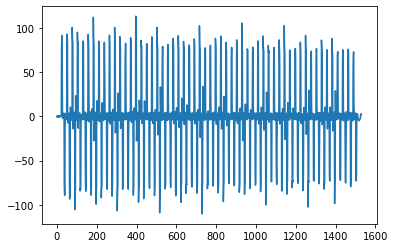

In [105]:
# time = np.linspace(0, RunTime, int(RunTime / SampleTime) + 1, endpoint=True)
# data = loadmat('data/voltages.mat')
# voltage1 = data['voltage']
# voltage2 = data['newVoltageShift1']
# voltage3 = data['newVoltageShift2']
# voltage4 = data['newVoltageShift3']
# plt.plot(time * 1e3, voltage1)
# plt.plot(time * 1e3, voltage3)
# plt.xlim(0, 0.5)
# plt.xlabel('Time (ms)')
# plt.ylabel('Voltages (V)')
# plt.show()
# print(np.shape(voltage1))

#Best cutoffs so far: 170:1965

data = loadmat('data/shot_220816005_data.mat')
vals = data['shot_220816005']
vals = vals[270:1800,:]
time = vals[:,0]
voltage1 = vals[:,1]
voltage2 = vals[:,2]
voltage3 = vals[:,3]
voltage4 = vals[:,4]



print(np.shape(voltage1))
plt.plot(voltage1)
inputs = (np.vstack([voltage1, voltage2, voltage3, voltage4]).T)
print(np.shape(inputs))

(1530, 12)


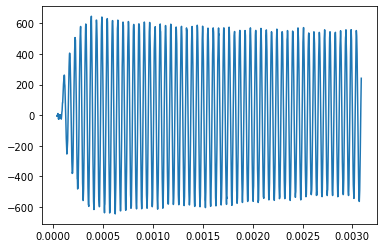

In [121]:
#Get all the states and state derivatives from data file
i_L1_1 = vals[:,5]
i_L1_2 = vals[:,11]
i_L1_3 = vals[:,17]
i_L1_4 = vals[:,23]


v_cap_1 = vals[:,6]
v_cap_2 = vals[:,12]
v_cap_3 = vals[:,18]
v_cap_4 = vals[:,24]

i_fcoil_1 = vals[:,7]
i_fcoil_2 = vals[:,13]
i_fcoil_3 = vals[:,19]
i_fcoil_4 = vals[:,25]

v_L1_1 = vals[:,8]
v_L1_2 = vals[:,14]
v_L1_3 = vals[:,20]
v_L1_4 = vals[:,26]

i_cap_1 = vals[:,9]
i_cap_2 = vals[:,15]
i_cap_3 = vals[:,21]
i_cap_4 = vals[:,27]

v_fcoil_1 = vals[:,10]
v_fcoil_2 = vals[:,16]
v_fcoil_3 = vals[:,22]
v_fcoil_4 = vals[:,28]

circuit_1_states = np.vstack([i_L1_1,v_cap_1,i_fcoil_1]).T
circuit_2_states = np.vstack([i_L1_2,v_cap_2,i_fcoil_2]).T
circuit_3_states = np.vstack([i_L1_3,v_cap_3,i_fcoil_3]).T
circuit_4_states = np.vstack([i_L1_4,v_cap_4,i_fcoil_4]).T

circuit_1_state_deriv = np.vstack([v_L1_1,i_cap_1,v_fcoil_1]).T
circuit_2_state_deriv = np.vstack([v_L1_2,i_cap_2,v_fcoil_2]).T
circuit_3_state_deriv = np.vstack([v_L1_3,i_cap_3,v_fcoil_3]).T
circuit_4_state_deriv = np.vstack([v_L1_4,i_cap_4,v_fcoil_4]).T

states = np.hstack([circuit_1_states,circuit_2_states,circuit_3_states,circuit_4_states])

state_derivatives = np.hstack([circuit_1_state_deriv,circuit_2_state_deriv,circuit_3_state_deriv,circuit_4_state_deriv])

print(np.shape(states))

plt.plot(time,i_fcoil_1)

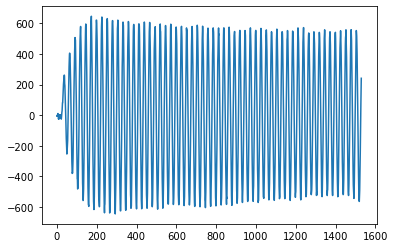

In [107]:
np.shape(inputs)
plt.plot(i_fcoil_1)

## Output and plots of the analytic state space model run with the SPA voltage from the shot

Text(0.5, 1.0, 'Output of analytic state space model')

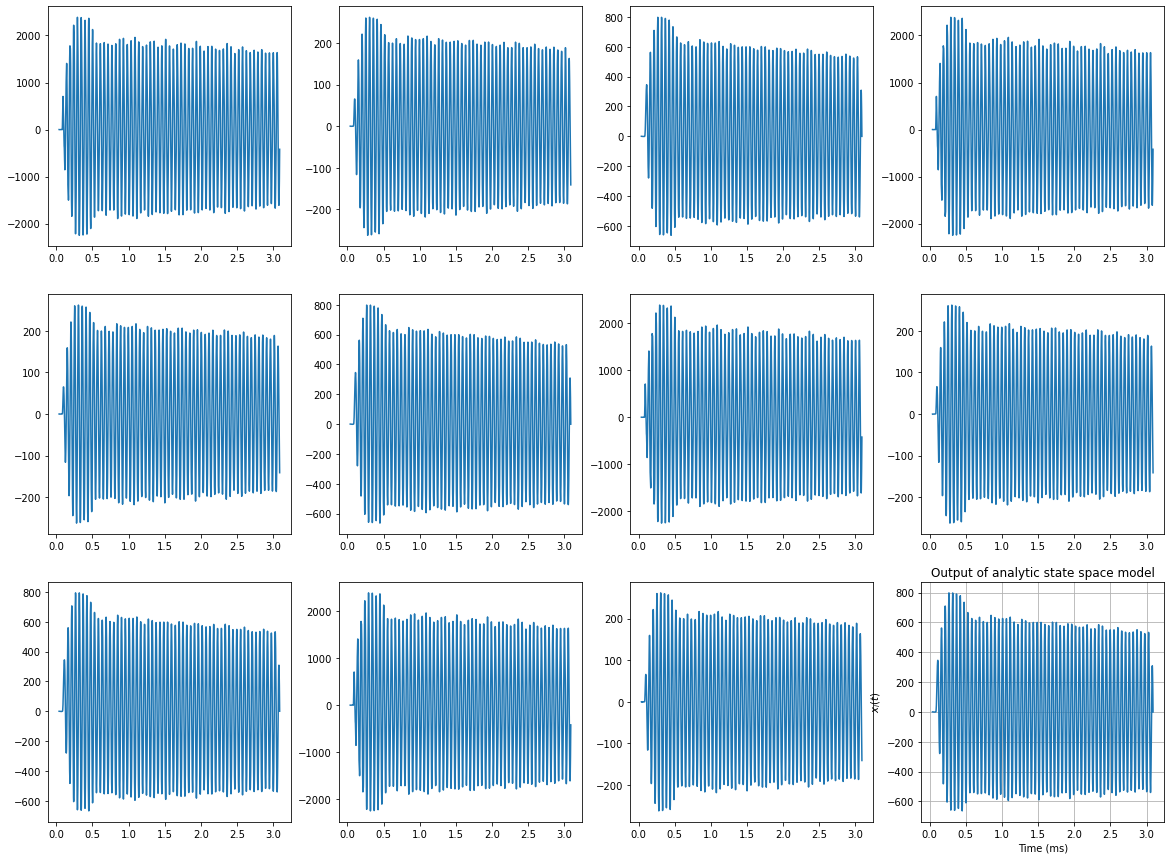

In [125]:
#inputs = np.hstack([voltage1, voltage2, voltage3, voltage4])

yout,tout, xout = lsim(
    sysc, 
    inputs, 
    time
)

# Add some noise proportional to the signal with the smallest amplitude of the 12
rmse = mean_squared_error(xout[:, 1], np.zeros(xout[:, 1].shape), squared=False)
xout = xout + np.random.normal(0, rmse / 100.0 * .1, xout.shape)  # add modest 0.1% noise

#Kalman Filter

# print(np.shape(tout))

# L,P,E = lqe(sysc, Q,R)

# syskf = ss(A-L*C, np.hstack((B,L)), np.identity(12), 0*np.hstack((B,L)))

# plt.figure()

# L2_currents = np.vstack([xout[:,2], xout[:,5], xout[:,8], xout[:,11]])


# inputs_for_kf = np.hstack([inputs, L2_currents.T])

# kf_t, kf_y, kf_x = lsim(syskf, inputs_for_kf,time)

# Could consider rescaling units here



xout = xout
yout = yout
tout = tout
dt = tout[1] - tout[0]

plt.figure(figsize=(20,15))
for i in range(1,13):
    plt.subplot(3,4,i)
    plt.plot(time * 1000, xout[:, i-1])
plt.grid(True)
plt.xlabel('Time (ms)')
plt.ylabel(r'$x_i(t)$')
plt.title('Output of analytic state space model')


In [126]:
# plt.figure()
# plt.plot(kf_x[:,0], '*k')
# plt.plot(xout[:,0], 'r')

np.shape(xout)
time[-1]

0.0030890067989999387

### Discover the dx/dt = Ax + Bu part of the state space model
Try STLSQ instead -- you will likely get an unstable model! Below we use a special optimizer to make sure the linear matrix is stable. $\nu \ll 1$ promotes stability.

In [ ]:
# Define the control input
u = inputs
sindy_library = ps.PolynomialLibrary(degree=1, include_bias=False)

library_functions = [lambda x: x]
library_function_names = [lambda x: x]

dt = time[1]-time[0]
t_train = time

ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    is_uniform=True,
    K=100,
)

#Does this impact the B matrix stability?

optimizer_stable = ps.StableLinearSR3(
    threshold=0,
    thresholder='l1',
    nu=1e-9, #1e-9 and 25000 iterations gives a negative definite A-matrix for the regular form of SINDy
    max_iter=25000,
    tol=1e-5,
    verbose=True,
)


#weak form 
# model = ps.SINDy(feature_library=ode_lib ,optimizer=optimizer_stable)


#regular form
model = ps.SINDy(feature_library=sindy_library ,optimizer=optimizer_stable, differentiation_method=ps.SmoothedFiniteDifference(smoother_kws={'window_length':29}))

model.fit(states, t=tout, u=u)

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 2.0520e+23 ... 2.8655e+22 ... 0.0000e+00 ... 2.0520e+23
      2500 ... 2.1895e+20 ... 2.3952e+19 ... 0.0000e+00 ... 2.1895e+20
      5000 ... 2.1896e+20 ... 1.9153e+19 ... 0.0000e+00 ... 2.1896e+20
      7500 ... 2.8256e+20 ... 2.2403e+19 ... 0.0000e+00 ... 2.8256e+20


In [111]:
optimizer_stable = ps.StableLinearSR3(
    threshold=0,
    thresholder='l1',
    nu=1e-10, #1e-9 and 25000 iterations gives a negative definite A-matrix for the regular form of SINDy
    max_iter=25000,
    tol=1e-5,
    verbose=False,
)


ensemble_optimizer = ps.EnsembleOptimizer(optimizer_stable, bagging=True, library_ensemble = False, n_models = 5)

model_ensemble = ps.SINDy(feature_library=sindy_library ,optimizer=ensemble_optimizer, differentiation_method=ps.SmoothedFiniteDifference(smoother_kws={'window_length':29}))

model_ensemble.fit(states, t=tout, u=u)


C:\Users\ducks\pysindy\pysindy\optimizers\stable_linear_sr3.py:300: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i, i] = self.gamma + np.imag(eigvals[i]) * 1j
C:\Users\ducks\pysindy\pysindy\optimizers\stable_linear_sr3.py:431: ConvergenceWarning: StableLinearSR3._reduce did not converge after 25000 iterations.
  warnings.warn(
C:\Users\ducks\pysindy\pysindy\optimizers\stable_linear_sr3.py:431: ConvergenceWarning: StableLinearSR3._reduce did not converge after 25000 iterations.
  warnings.warn(
C:\Users\ducks\pysindy\pysindy\optimizers\stable_linear_sr3.py:431: ConvergenceWarning: StableLinearSR3._reduce did not converge after 25000 iterations.
  warnings.warn(
C:\Users\ducks\pysindy\pysindy\optimizers\stable_linear_sr3.py:431: ConvergenceWarning: StableLinearSR3._reduce did not converge after 25000 iterations.
  warnings.warn(
C:\Users\ducks\pysindy\pysindy\optimizers\stable_linear_sr3.py:431: ConvergenceWarning: StableLinearSR3._reduce did not converg

SINDy(differentiation_method=SmoothedFiniteDifference(smoother_kws={'axis': 0,
                                                                    'polyorder': 3,
                                                                    'window_length': 29}),
      feature_library=PolynomialLibrary(degree=1, include_bias=False),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
                     'x10', 'x11', 'u0', 'u1', 'u2', 'u3'],
      optimizer=EnsembleOptimizer(bagging=True, n_models=10, n_subset=918,
                                  opt=StableLinearSR3(max_iter=25000, nu=1e-10,
                                                      threshold=0)))

### Without noise, can match A and B matrices quite well

In [112]:
np.linalg.eigvals(model.optimizer.coef_[0:12,0:12])

array([-21014.83837235   +0.j        ,  -5476.13054216+3520.81822138j,
        -5476.13054216-3520.81822138j,  -6561.65979988   +0.j        ,
        -2979.00820536 +339.7127608j ,  -2979.00820536 -339.7127608j ,
        -2128.04921514   +0.j        ,  -1342.88913416   +0.j        ,
          -71.95314967   +0.j        ,   -129.62448704  +39.09654897j,
         -129.62448704  -39.09654897j,   -200.42202764   +0.j        ])

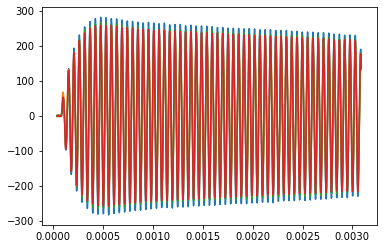

In [113]:
plt.plot(time,v_cap_4)
plt.plot(time,v_cap_3)
plt.plot(time,v_cap_2)
plt.plot(time,v_cap_1)

## Here we try to average the ensembled models

In [114]:
model_list = model_ensemble.optimizer.coef_list
print(np.shape(model_list[0]))

model_sum = 0
num_models = len(model_list)
for i in model_list:
    model_sum += i
model_avg = model_sum/num_models
model_avg_A = model_avg[:,0:12]
model_avg_B = model_avg[:,12:16]


print(np.shape(model_avg_B))
print(np.linalg.eigvals(model_avg_A))

(12, 16)
(12, 4)
[-28007.24077187  +0.j         -23457.60799026+281.34897671j
 -23457.60799026-281.34897671j -20895.24225523  +0.j
 -15957.11398382  +0.j         -13804.67779927  +0.j
    265.17315773  +0.j          -5318.82829063  +0.j
  -3804.80523621  +0.j          -1725.79868023  +0.j
  -2466.37107663  +0.j          -2919.15339011  +0.j        ]


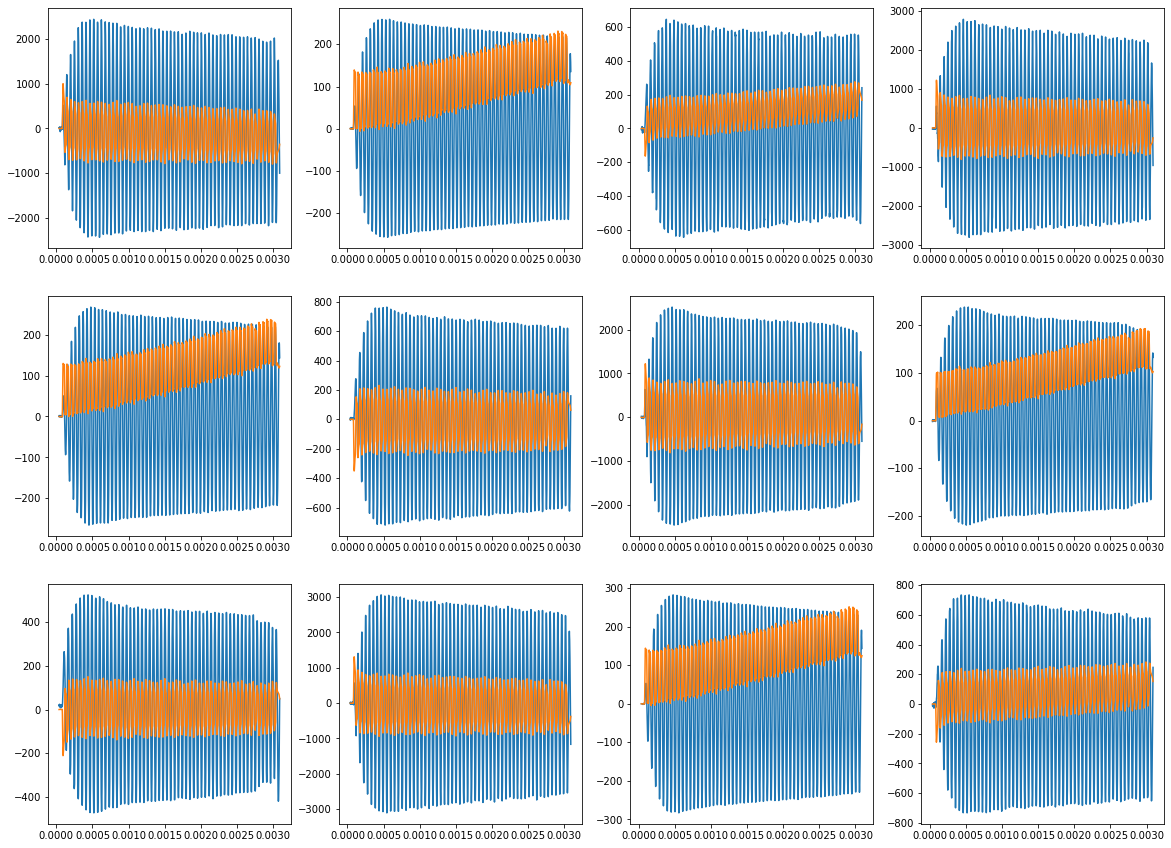

In [115]:
#This is the ensembled and averaged state space model

sysc_ensemble = ss(model_avg_A,model_avg_B,C,D)

y_pred,t_pred,x_pred = lsim(sysc_ensemble,inputs,time)

plt.figure(figsize=(20,15))

for i in range(1,13):
    plt.subplot(3,4,i)
    plt.plot(time,states[:,i-1])
    plt.plot(time,x_pred[:,i-1])

In [116]:
Xi = model.coefficients()
r = Xi.shape[0]
B_SINDy = Xi[:r, r:]
A_SINDy = Xi[:r, :r]



def normalized_error(matrix_true, matrix_pred):
    return np.linalg.norm(matrix_true - matrix_pred) / np.linalg.norm(matrix_true)
    
print(normalized_error(A, A_SINDy))
print(normalized_error(B, B_SINDy))

A_pred = (model.optimizer.coef_[:,0:12])

B_pred = model.optimizer.coef_[:,12:16]

sysc_pred = StateSpace(A_pred,B_pred,C,D)

print(np.linalg.eigvals(A_pred))

0.9868216138912245
0.8966680208427023
[-21014.83837235   +0.j          -5476.13054216+3520.81822138j
  -5476.13054216-3520.81822138j  -6561.65979988   +0.j
  -2979.00820536 +339.7127608j   -2979.00820536 -339.7127608j
  -2128.04921514   +0.j          -1342.88913416   +0.j
    -71.95314967   +0.j           -129.62448704  +39.09654897j
   -129.62448704  -39.09654897j   -200.42202764   +0.j        ]


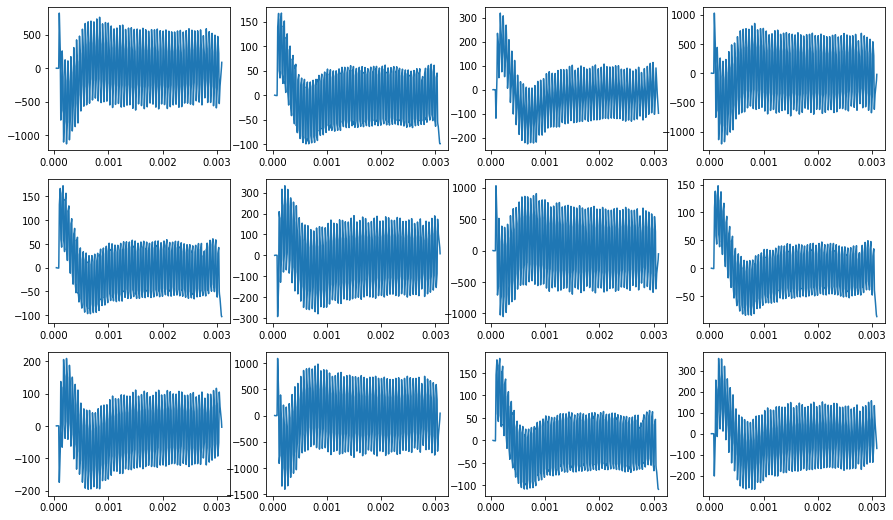

In [117]:
y_pred,t_pred,x_pred = lsim(sysc_pred,inputs,time)

plt.figure(figsize=(15,9))

for i in range(1,13):
    plt.subplot(3,4,i)
    plt.plot(time,x_pred[:,i-1])

In [118]:
# ydot_true = model.differentiate(states, t=tout)
# ydot_pred = model.predict(states, u=u)
# plt.figure(figsize=(18, 8))
# for i in range(12):
#     plt.subplot(4, 3, i + 1)
#     plt.grid(True)
#     plt.plot(tout, ydot_true[:, i], 'k')
#     plt.plot(tout, ydot_pred[:, i], 'r--')

print('Eigenvalues of weak form model:')



weak_model_coef = model.optimizer.coef_


Eigenvalues of weak form model:


Because we just used the weak form, we need to now take the model coefficients and 'stuff' them into a new, fresh, and fun SINDy model that will be able to actually form predictions. Because the weak form uses the integral formulation, when we use model.predict, we get a prediction of x and not a prediction of x_dot. 

In [119]:
# # Instantiate and fit a non-weak SINDy model
# ode_lib = ps.CustomLibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
#     include_bias=False,
# )

# optimizer_stable = ps.StableLinearSR3(
#     threshold=10.0,
#     thresholder='l1',
#     nu=1e-7,
#     max_iter=20000,
#     tol=1e-5,
#     verbose=True,
    
    
# )

# original_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer_stable)
# original_model.fit(states, t=time,u=inputs, quiet=True)

# original_model.coef_= weak_model_coef

# x0_new = (np.random.rand(12) - 0.5) * 10000

# states = original_model.simulate(x0_new, t=t_train, u=inputs, integrator='odeint')


# # state_pred = original_model.predict(inputs)

NameError: name 'ydot_pred' is not defined

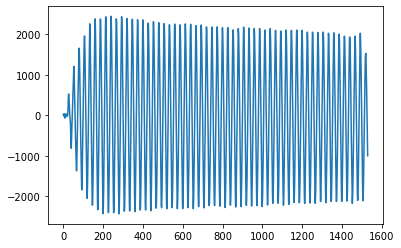

In [120]:
plt.figure()
plt.plot(states[:,0])

plt.plot(ydot_pred[:,0])



plt.legend(['ydot true','ydot predicted'])

### Check if the A matrix is negative definite!
If not all the eigenvalues are negative, model is eventually unstable. If so, optimize with the StableLinearOptimizer until the eigenvalues are pushed to be all negative. 

In [ ]:
Xi = model_avg
print(np.sort(np.linalg.eigvals(Xi[:12, :12])))

### Now try resimulating the training data from some new initial condition
This is a 12D system and the time base is VERY well-sampled so integration might take a while!

In [ ]:
x0_new = (np.random.rand(12) - 0.5) * 10000 
print(np.shape(x0_new))

yout,tout, xout = lsim(
    sysc, 
    u, 
    time,
    X0=x0_new,
)
print(np.shape(time))

print(np.shape(tout))
print(np.shape(yout))
print(np.shape(xout))
x_pred = model.simulate(
    x0_new, 
    t=tout[:int(len(tout) // 2):10], 
    u=u[:int(len(tout) // 2):10, :]
)



In [ ]:
plt.figure(figsize=(18, 8))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.plot(time, xout[:, i], 'k')
    plt.plot(tout[:int(len(tout) // 2) - 10:10], x_pred[:, i], 'r')